In [1]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer
import torch
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

/homes10/klkehl/miniconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# pulls in a previously created training/val/test DFCI dataset with one row per annotated oncologist note
# outcome annotations are any_cancer, progression, and response, each of which is a binary variable
# mixed response counts as progression
phi_data = pd.read_csv('/data/clin_notes_outcomes/profile_3-2023/derived_data/labeled_medonc_prissmm_mixedisprog.csv')



In [3]:
training = phi_data[phi_data.split=='train']
training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32173 entries, 0 to 39190
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0.1              32173 non-null  int64  
 1   dfci_mrn                  32173 non-null  float64
 2   cancer_type               32173 non-null  object 
 3   date                      32173 non-null  object 
 4   any_cancer                32173 non-null  int64  
 5   progression               32173 non-null  int64  
 6   response                  32173 non-null  int64  
 7   Unnamed: 0                32173 non-null  int64  
 8   text                      32173 non-null  object 
 9   PROVIDER_DEPARTMENT       32173 non-null  object 
 10  patient_id                32173 non-null  int64  
 11  hybrid_death_ind          32173 non-null  object 
 12  hybrid_death_dt           19552 non-null  object 
 13  primary_cancer_diagnosis  32173 non-null  object 
 14  genomi

In [4]:
training.dfci_mrn.nunique()

2917

In [5]:
validation = phi_data[phi_data.split=='validation']

validation.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3636 entries, 362 to 39187
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0.1              3636 non-null   int64  
 1   dfci_mrn                  3636 non-null   float64
 2   cancer_type               3636 non-null   object 
 3   date                      3636 non-null   object 
 4   any_cancer                3636 non-null   int64  
 5   progression               3636 non-null   int64  
 6   response                  3636 non-null   int64  
 7   Unnamed: 0                3636 non-null   int64  
 8   text                      3636 non-null   object 
 9   PROVIDER_DEPARTMENT       3636 non-null   object 
 10  patient_id                3636 non-null   int64  
 11  hybrid_death_ind          3636 non-null   object 
 12  hybrid_death_dt           2416 non-null   object 
 13  primary_cancer_diagnosis  3636 non-null   object 
 14  genom

In [6]:
test = phi_data[phi_data.split=='test']

test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3382 entries, 57 to 39088
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0.1              3382 non-null   int64  
 1   dfci_mrn                  3382 non-null   float64
 2   cancer_type               3382 non-null   object 
 3   date                      3382 non-null   object 
 4   any_cancer                3382 non-null   int64  
 5   progression               3382 non-null   int64  
 6   response                  3382 non-null   int64  
 7   Unnamed: 0                3382 non-null   int64  
 8   text                      3382 non-null   object 
 9   PROVIDER_DEPARTMENT       3382 non-null   object 
 10  patient_id                3382 non-null   int64  
 11  hybrid_death_ind          3382 non-null   object 
 12  hybrid_death_dt           2160 non-null   object 
 13  primary_cancer_diagnosis  3382 non-null   object 
 14  genomi

In [7]:

from transformers import AutoModel



from torch.nn import functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import LSTM, Linear, Embedding, Conv1d, MaxPool1d, GRU, LSTMCell, Dropout, Module, Sequential, ReLU

   
class LabeledModel(nn.Module):

    def __init__(self, device='cuda'):
        super(LabeledModel, self).__init__()
        
        self.longformer = AutoModel.from_pretrained('yikuan8/Clinical-Longformer')
        self.any_cancer_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))
        self.response_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))
        self.progression_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))


        
    def forward(self, x_text_tensor, x_attention_mask):
        # x should be tuple of input IDs, then attention mask
        global_attention_mask = torch.zeros_like(x_text_tensor, device='cuda')
        # global attention on cls token
        global_attention_mask[:, 0] = 1
        main = self.longformer(x_text_tensor, x_attention_mask, global_attention_mask)
        main = main.last_hidden_state[:,0,:].squeeze(1)

                                          
        any_cancer_out = self.any_cancer_head(main)
        response_out = self.response_head(main)
        progression_out = self.progression_head(main)



        
        return any_cancer_out, response_out, progression_out
        




In [9]:
from torch.utils import data

class LabeledDataset(data.Dataset):
    def __init__(self, pandas_dataset):
        self.data = pandas_dataset.copy()
        self.indices = self.data.index.unique()
        self.tokenizer = AutoTokenizer.from_pretrained("yikuan8/Clinical-Longformer", truncation_side='left')        
        
        
    def __len__(self):
        # how many notes in the dataset
        return len(self.indices)
    
    def __getitem__(self, index):
        # get data for notes corresponding to indices passed
        this_index = self.indices[index]
        pand = self.data.loc[this_index, :]
        #label = torch.tensor(pand.progression, dtype=torch.float32)
    
        encoded = self.tokenizer(pand['text'], padding='max_length', truncation=True)

        x_text_tensor = torch.tensor(encoded.input_ids, dtype=torch.long)
        x_attention_mask = torch.tensor(encoded.attention_mask, dtype=torch.long)
        
        y_any_cancer = torch.tensor(pand.any_cancer, dtype=torch.float32)
        y_response = torch.tensor(pand.response, dtype=torch.float32)
        y_progression = torch.tensor(pand.progression, dtype=torch.float32)
        


        return x_text_tensor, x_attention_mask, y_any_cancer, y_response, y_progression
        
        

In [10]:
# train loop
from transformers import get_scheduler
from torch.optim import AdamW, Adam
#, get_linear_schedule_with_warmup


def train_model(model, num_epochs, trainloader, validloader=None, device='cuda'):
    
    

    optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    num_training_steps = num_epochs * len(trainloader)
    lr_scheduler = get_scheduler(
        name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

    model.to(device)
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_train_losses = [0.0 for i in range(3)]
        mean_train_losses = [0.0 for i in range(3)]
        
        running_valid_losses = [0.0 for i in range(3)]
        mean_valid_losses = [0.0 for i in range(3)]

        num_train_batches = len(trainloader)
                
        model.train()
        
        for i, batch in enumerate(trainloader, 0):
            input_ids = batch[0].to(device)
            input_masks = batch[1].to(device)
            
            optimizer.zero_grad()
            
            outputs_true = [x.to(device) for x in batch[2:]]
            
            outputs_pred = model(input_ids, input_masks)
            
           
            losses = [F.binary_cross_entropy_with_logits(outputs_pred[x].squeeze(1), outputs_true[x]) for x in range(3)]
            
            total_loss = 0.0
            for j in range(3):
                total_loss = total_loss + losses[j]

                
            total_loss.backward()
            optimizer.step()
            lr_scheduler.step()
            
            
            for j in range(3):
                running_train_losses[j] += losses[j].detach().cpu().numpy()
                mean_train_losses[j] = running_train_losses[j] / (i+1)
                
            print('Training Epoch: ' + str(epoch+1) + ', batch: ' + str(i + 1) + '/' + str(num_train_batches) + ' this_loss:' + str(total_loss.detach().cpu().numpy()) +', train losses: ' + str([str(x) + ': ' + str(mean_train_losses[x]) + ", " for x in range(3)]), end='\r', flush=True)
        
        print('\n')
        # eval on valid
        
        if validloader is not None:
            num_valid_batches = len(validloader)
            model.eval()
            
            for i, batch in enumerate(validloader, 0):
                input_ids = batch[0].to(device)
                input_masks = batch[1].to(device)


                outputs_true = [x.to(device) for x in batch[2:]]

                outputs_pred = model(input_ids, input_masks)

                losses = [F.binary_cross_entropy_with_logits(outputs_pred[x].squeeze(1), outputs_true[x]) for x in range(3)]

                total_loss = 0.0
                for j in range(3):
                    total_loss = total_loss + losses[j]
                


                for j in range(3):
                    running_valid_losses[j] += losses[j].detach().cpu().numpy()

            
            for j in range(3):
                mean_valid_losses[j] = running_valid_losses[j] / (i+1)
            

            
            print('Validation Epoch: ' + str(epoch+1) + ', batch: ' + str(i + 1) + '/' + str(num_valid_batches) + ', valid losses: ' + str([str(x) + ': ' + str(mean_valid_losses[x]) + ", " for x in range(3)]), end='\r', flush=True)
            print('\n')

    

In [ ]:
# this actually trains the PHI teacher model when uncommented.

#from torch.nn import DataParallel

# themodel = LabeledModel()
# trainloader = data.DataLoader(LabeledDataset(training.reset_index(drop=True)), batch_size=8, num_workers=8, shuffle=True)
# validloader = data.DataLoader(LabeledDataset(validation.reset_index(drop=True)), batch_size=4, num_workers=8, shuffle=True)
# train_model(themodel,3, trainloader, device='cuda')

In [10]:
#torch.save(themodel.state_dict(), 'dfci_phi_note_longformer.pt')

In [11]:
# write out actual validation dataset
themodel = LabeledModel()
themodel.load_state_dict(torch.load('dfci_phi_note_longformer.pt'))
themodel.to('cuda')

themodel.eval()

no_shuffle_valid_dataset = data.DataLoader(LabeledDataset(validation), batch_size=4, shuffle=False, num_workers=0)

output_true_lists = [[] for x in range(3)]
output_prediction_lists = [[] for x in range(3)]
for batch in no_shuffle_valid_dataset:
    #thisframe = pd.DataFrame()
    x_text_ids = batch[0].to('cuda')
    x_attention_mask = batch[1].to('cuda')
    with torch.no_grad():
        predictions = themodel(x_text_ids, x_attention_mask)
    for j in range(3):
        output_true_lists[j].append(batch[2+j].detach().cpu().numpy())
        output_prediction_lists[j].append(predictions[j].detach().cpu().numpy())

output_true_lists = [np.concatenate(x) for x in output_true_lists]        
output_prediction_lists = [np.concatenate(x) for x in output_prediction_lists]


output_validation = validation.copy()
for x in range(3):
    output_validation['outcome_' + str(x) + '_logit'] = output_prediction_lists[x]



Some weights of the model checkpoint at yikuan8/Clinical-Longformer were not used when initializing LongformerModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerModel were not initialized from the model checkpoint at yikuan8/Clinical-Longformer and are newly initialized: ['longformer.pooler.dense.bias', 'longformer.pooler.dense.weight']
You should probably TRAIN this model on a dow

In [1]:
#output_validation.head()

In [13]:
from sklearn.metrics import roc_auc_score


In [14]:
[print(roc_auc_score(output_true_lists[x], output_prediction_lists[x])) for x in range(3)]

0.9655435387768156
0.9642538170798717
0.9580866164623698


[None, None, None]

In [15]:
from utils_102023 import *

AUC 0.9655435387768156
Outcome probability: 0.8006050605060506
Average precision score: 0.99
Best F1: 0.960876897133221


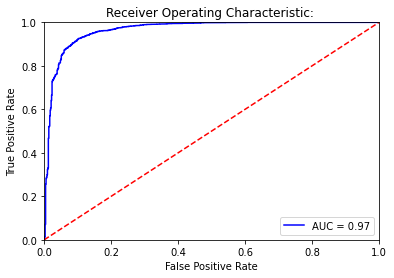

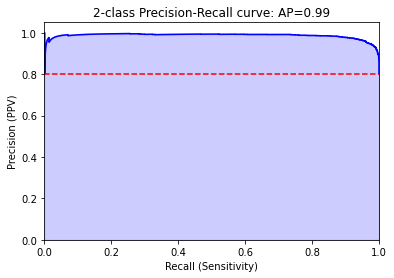

Threshold for best F1:
-2.4331982
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[ 555  170]
 [  62 2849]]


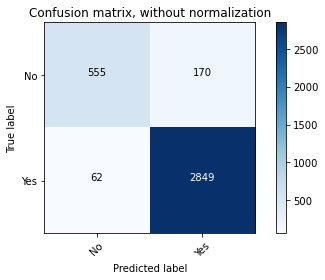

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.90      0.77      0.83       725
         Yes       0.94      0.98      0.96      2911

    accuracy                           0.94      3636
   macro avg       0.92      0.87      0.89      3636
weighted avg       0.93      0.94      0.93      3636

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[ 627   98]
 [ 166 2745]]


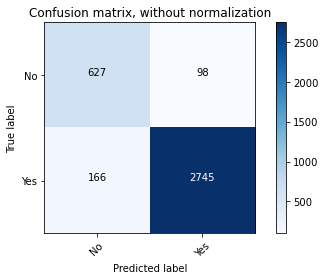

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.79      0.86      0.83       725
         Yes       0.97      0.94      0.95      2911

    accuracy                           0.93      3636
   macro avg       0.88      0.90      0.89      3636
weighted avg       0.93      0.93      0.93      3636



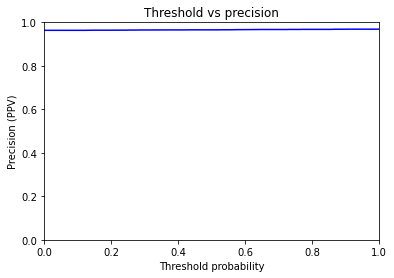

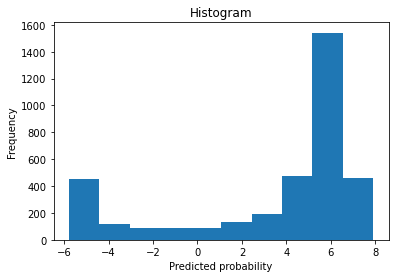

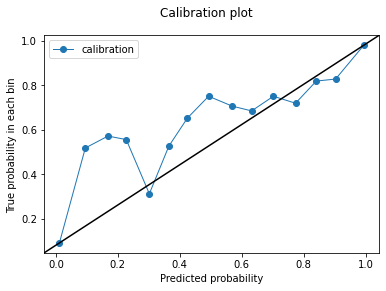

-2.4331982

In [16]:
eval_model(output_prediction_lists[0], output_true_lists[0], graph=True)

AUC 0.9642538170798717
Outcome probability: 0.13063806380638063
Average precision score: 0.82
Best F1: 0.7933070866141733


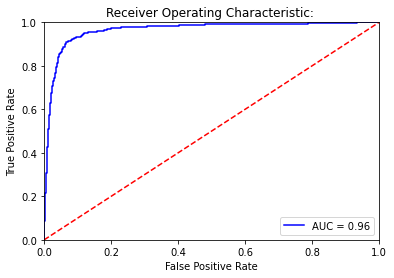

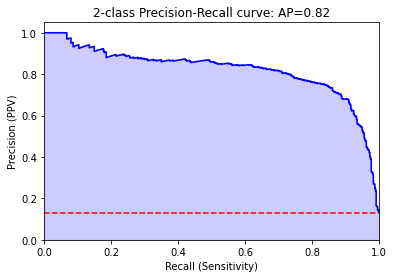

Threshold for best F1:
-0.45919663
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[3023  138]
 [  72  403]]


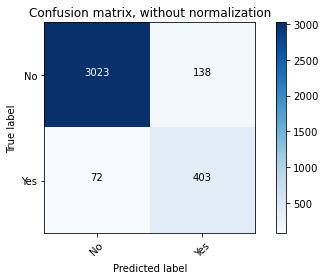

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.98      0.96      0.97      3161
         Yes       0.74      0.85      0.79       475

    accuracy                           0.94      3636
   macro avg       0.86      0.90      0.88      3636
weighted avg       0.95      0.94      0.94      3636

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[3049  112]
 [ 102  373]]


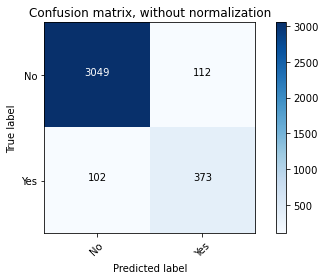

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.97      0.96      0.97      3161
         Yes       0.77      0.79      0.78       475

    accuracy                           0.94      3636
   macro avg       0.87      0.87      0.87      3636
weighted avg       0.94      0.94      0.94      3636



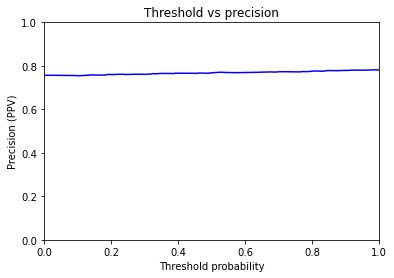

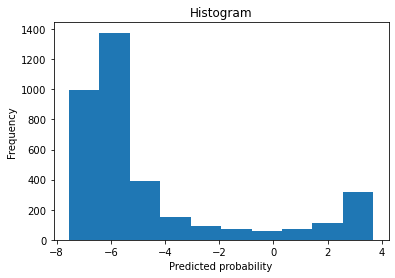

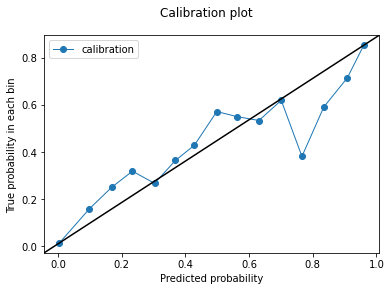

-0.45919663

In [17]:
eval_model(output_prediction_lists[1], output_true_lists[1], graph=True)

AUC 0.9580866164623698
Outcome probability: 0.1806930693069307
Average precision score: 0.86
Best F1: 0.7703814510097231


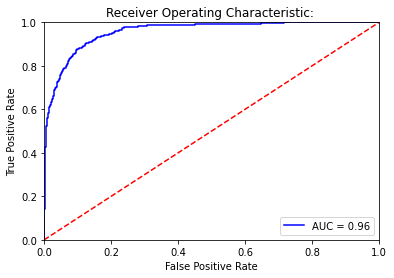

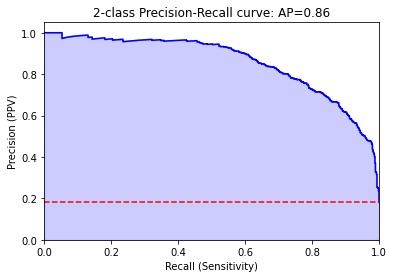

Threshold for best F1:
-0.17282332
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[2814  165]
 [ 142  515]]


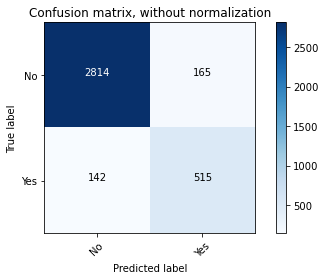

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.95      0.94      0.95      2979
         Yes       0.76      0.78      0.77       657

    accuracy                           0.92      3636
   macro avg       0.85      0.86      0.86      3636
weighted avg       0.92      0.92      0.92      3636

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[2859  120]
 [ 179  478]]


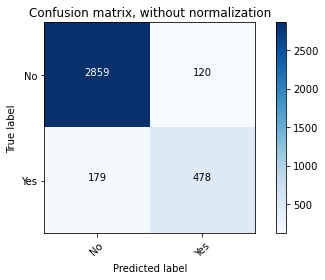

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.94      0.96      0.95      2979
         Yes       0.80      0.73      0.76       657

    accuracy                           0.92      3636
   macro avg       0.87      0.84      0.86      3636
weighted avg       0.92      0.92      0.92      3636



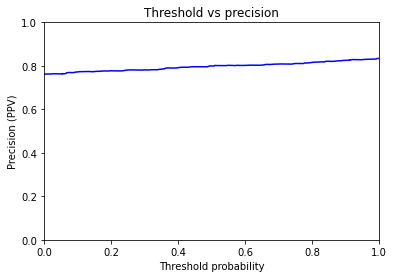

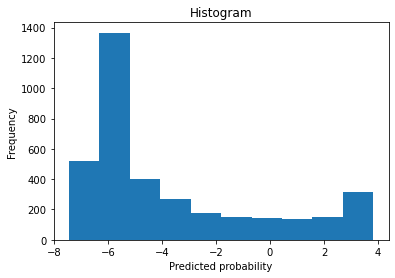

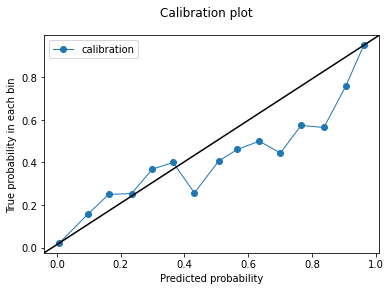

-0.17282332

In [18]:
eval_model(output_prediction_lists[2], output_true_lists[2], graph=True)

In [19]:
# write out actual test dataset
themodel = LabeledModel()
themodel.load_state_dict(torch.load('dfci_phi_note_longformer.pt'))
themodel.to('cuda')

themodel.eval()

no_shuffle_valid_dataset = data.DataLoader(LabeledDataset(test), batch_size=4, shuffle=False, num_workers=0)

output_true_lists = [[] for x in range(3)]
output_prediction_lists = [[] for x in range(3)]
for batch in no_shuffle_valid_dataset:
    #thisframe = pd.DataFrame()
    x_text_ids = batch[0].to('cuda')
    x_attention_mask = batch[1].to('cuda')
    with torch.no_grad():
        predictions = themodel(x_text_ids, x_attention_mask)
    for j in range(3):
        output_true_lists[j].append(batch[2+j].detach().cpu().numpy())
        output_prediction_lists[j].append(predictions[j].detach().cpu().numpy())

output_true_lists = [np.concatenate(x) for x in output_true_lists]        
output_prediction_lists = [np.concatenate(x) for x in output_prediction_lists]


output_test = test.copy()
for x in range(3):
    output_test['outcome_' + str(x) + '_logit'] = output_prediction_lists[x]



Some weights of the model checkpoint at yikuan8/Clinical-Longformer were not used when initializing LongformerModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerModel were not initialized from the model checkpoint at yikuan8/Clinical-Longformer and are newly initialized: ['longformer.pooler.dense.bias', 'longformer.pooler.dense.weight']
You should probably TRAIN this model on a dow

In [20]:
[print(roc_auc_score(output_true_lists[x], output_prediction_lists[x])) for x in range(3)]

0.9531482355848361
0.971492554025305
0.9614256542383772


[None, None, None]

In [21]:
#output_test.to_csv('../data/dfci_phi_medonc_eval_on_test.csv')